# Time series
75033710 rows

13713 unique time series taken in 12603 stations from 17-10-2000 to 22-03-2018

In [30]:
import pyarrow.feather as feather
import pandas as pd
import numpy as np
from scipy.io import netcdf
import matplotlib.pyplot as plt 

In [4]:
time_series_df = feather.read_feather('dataset/original_data_as_feather')

In [5]:
time_series_df.head()

,proj_id,name,date,groundwater_level
0,BB_25470023,Ottenhagen OP,2000-10-17 00:00:00+00:00,79.01
1,BB_25470023,Ottenhagen OP,2000-11-22 00:00:00+00:00,78.96
2,BB_25470023,Ottenhagen OP,2000-12-18 00:00:00+00:00,78.94
3,BB_25470023,Ottenhagen OP,2001-01-11 00:00:00+00:00,79.02
4,BB_25470023,Ottenhagen OP,2001-02-06 00:00:00+00:00,78.99


In [14]:
len(time_series_df)

75033710

In [12]:
len(time_series_df["proj_id"].unique())

13713

In [13]:
len(time_series_df["name"].unique())

12603

In [23]:
pd.DataFrame(data=(time_series_df.loc[time_series_df.index[0]],time_series_df.loc[time_series_df.index[-1]]))

,proj_id,name,date,groundwater_level
0,BB_25470023,Ottenhagen OP,2000-10-17 00:00:00+00:00,79.01
75033709,TH_5730000077,Br.Lindenau (0006),2018-03-22 00:00:00+00:00,281.41


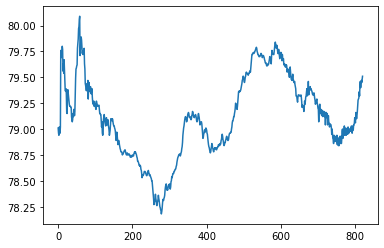

In [19]:
t_s_1 = time_series_df[time_series_df["proj_id"]=="BB_25470023"]
plt.plot(t_s_1["groundwater_level"])

# metadata: 
respective observation wells ( stations),

related to the equipment used in the measurement e.g. coordinates, filter depth

13492 rows, 15 feature
latitude and longitude of stations are taken from here

In [25]:
meta_df = pd.read_excel("dataset/metadata_timeseries_LongLat.xlsx")
meta_df.head()

,proj_id,name,x_long,y_lat,x_utm32,y_utm32,aquifer_id,filteroberkante,filterunterkante,filter_length,filter_depth_middle,surface_elevation,watertable_pressure,well_depth,aquifer_level
0,BB_25470023,Ottenhagen OP,13.643609,53.416804,808527.0,5928687.0,weitgehend bedeckter GWL,NaN,NaN,NaN,NaN,"100,33",gespannt,"62,53",NaN
1,BB_25470024,Ottenhagen UP,13.643653,53.416793,808530.0,5928686.0,tieferer GWL in tiefern quart. und tert. Schic...,NaN,NaN,NaN,NaN,"100,38",NaN,"45,68",NaN
2,BB_25480025,Neumannshof,13.826532,53.452024,820407.0,5933409.0,weitgehend bedeckter GWL,NaN,NaN,NaN,NaN,"58,94",gespannt,"10,84",NaN
3,BB_25480026,Amalienhof,13.677407,53.457078,810477.0,5933310.0,weitgehend bedeckter GWL,NaN,NaN,NaN,NaN,"97,67",gespannt,"62,67",NaN
4,BB_25481088,"Milow, Beschaffenheitsmesst.OP",13.821475,53.475857,819892.0,5936035.0,weitgehend unbedeckter GWL,NaN,NaN,NaN,NaN,"57,6",gespannt,"19,71",NaN


In [26]:
meta_df.shape

(13492, 15)

In [29]:
len(meta_df["proj_id"].unique())

13492

 ### predictors ( temperature and precipitation) are matched to the station lon lat acording these meta data

# temperature: as predictor

Daily means of hourly grids of air temperature for whole Germany (project TRY Advancement)

there are 215 NC files, each file represents a month of dailly temperature from 01-1995 tp 11-2012



In [121]:
# extract the dates in which water level were measured
# store the unique values in numpy array as str
available_t_s_dates = pd.Series(time_series_df["date"].unique())
available_t_s_dates = np.asanyarray(available_t_s_dates.apply(lambda x:''.join(str(x.date()).split("-"))))
available_t_s_dates

array(['20001017', '20001122', '20001218', ..., '20170815', '20171114',
       '20180220'], dtype=object)

In [122]:
available_t_s_dates.shape

(5607812,)

In [246]:
station_temp_df = meta_df[["proj_id","x_long", "y_lat"]]
station_temp_df.head()

,proj_id,x_long,y_lat
0,BB_25470023,13.643609,53.416804
1,BB_25470024,13.643653,53.416793
2,BB_25480025,13.826532,53.452024
3,BB_25480026,13.677407,53.457078
4,BB_25481088,13.821475,53.475857


In [247]:
station_temp_df.shape

(13492, 3)

In [33]:
# extract relevant temp from an nc file 
# each file has temperature across whole germany
dir_01_2005 = "dataset/project_try_dwd/data/"+'daily_Project_TRY_air_temperature_mean__TT_200501_daymean.nc'
temp_01_2005 = netcdf.NetCDFFile(dir_01_2005,'r')

In [37]:
temp_01_2005.variables

OrderedDict([('lon', <scipy.io.netcdf.netcdf_variable at 0x7f085c010400>),
             ('lat', <scipy.io.netcdf.netcdf_variable at 0x7f085abf65e0>),
             ('time', <scipy.io.netcdf.netcdf_variable at 0x7f085abf69d0>),
             ('time_bnds',
              <scipy.io.netcdf.netcdf_variable at 0x7f085abf6490>),
             ('datum', <scipy.io.netcdf.netcdf_variable at 0x7f085abf6bb0>),
             ('temperature',
              <scipy.io.netcdf.netcdf_variable at 0x7f085abf6c10>)])

In [215]:
germany_temp_df = pd.DataFrame(list(temp_01_2005.variables["lon"][:].flatten()), columns =["x_long"])

In [216]:
germany_temp_df["y_lat"] = list(temp_01_2005.variables["lat"][:].flatten())
germany_temp_df

,x_long,y_lat
0,5.5452,46.7198
1,5.5587,46.7204
2,5.5722,46.7209
3,5.5857,46.7215
4,5.5991,46.7221
...,...,...
675355,16.2843,55.3737
675356,16.3006,55.3729
675357,16.3168,55.3722
675358,16.3330,55.3714


In [165]:
germany_temp_df.isna().sum()

x_lon    0
y_lat    0
dtype: int64

In [133]:
# days of the month in the current nc file
days = temp_01_2005.variables["datum"][:]
days = [str(x)[:-4] for x in days]

In [237]:
# check if the day of the month relevant to the time series
for d, day in enumerate(days):
    if day in available_t_s_dates:
        germany_temp_df["t_"+str(day)] = list(temp_01_2005.variables["temperature"][d,:,:].flatten())
        #bdf[str(d)] = temp_01_2005.variables["temperature"][d,:,:].flatten()
        #pd.merge(station_temp_df, germany_temp_df, on='x_long', how="left")

In [238]:
germany_temp_df.head()

,x_long,y_lat,t_20050101,t_20050102,t_20050103,t_20050104,t_20050105,t_20050106,t_20050107,t_20050108,...,t_20050122,t_20050123,t_20050124,t_20050125,t_20050126,t_20050127,t_20050128,t_20050129,t_20050130,t_20050131
0,5.5452,46.7198,9999,9999,9999,9999,9999,9999,9999,9999,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
1,5.5587,46.7204,9999,9999,9999,9999,9999,9999,9999,9999,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
2,5.5722,46.7209,9999,9999,9999,9999,9999,9999,9999,9999,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
3,5.5857,46.7215,9999,9999,9999,9999,9999,9999,9999,9999,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999
4,5.5991,46.7221,9999,9999,9999,9999,9999,9999,9999,9999,...,9999,9999,9999,9999,9999,9999,9999,9999,9999,9999


In [255]:
germany_temp_df["x_long"]-station_temp_df["x_long"]

0        -8.098409
1        -8.084953
2        -8.254332
3        -8.091707
4        -8.222375
            ...   
675355         NaN
675356         NaN
675357         NaN
675358         NaN
675359         NaN
Name: x_long, Length: 675360, dtype: float64

In [258]:
np.asarray(germany_temp_df["x_long"]) - np.asarray(station_temp_df["x_long"])

ValueError: operands could not be broadcast together with shapes (675360,) (13492,) 